In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import docx

# Load data

In [101]:
df = pd.read_csv('results/results_clean_common.csv')

In [102]:
df.head()

,method,mean_test_score,min_test_score,max_test_score,var_test_score,mean_train_score,min_train_score,max_train_score,var_train_score,basis,lag_time,n_components,n_clusters
0,bayesian,1.365817,1.173453,1.639793,0.024526,2.961204,2.929818,2.996338,0.000734,close_cont,868,7,216
1,bayesian,1.102779,1.068484,1.143216,0.000681,1.986818,1.902030,2.080217,0.003915,chi_tor,123,8,719
2,bayesian,1.599413,1.186124,2.459781,0.196503,2.996799,2.995212,2.999155,0.000002,alpha_angle,528,9,503
3,bayesian,1.921110,1.266772,2.197571,0.119855,2.992483,2.982922,2.997997,0.000026,all_tor,909,6,245
4,bayesian,1.628841,1.490046,1.830204,0.016332,2.992354,2.986086,2.995805,0.000012,ca_cont,250,9,653


# Table: Summary

Rename for more sensible ordering

In [103]:
basis_rename = {'chi_tor': 'tor_chi', 'close_cont': 'cont_close', 'kappa_angle': 'angle_kappa', 
                'alpha_angle': 'tor_alpha', 'ca_cont': 'cont_ca', 'all_tor': 'tor_all', 'hb_pairs': 'pairs_hb'}
df.loc[:, 'basis'] = df.loc[:, 'basis'].apply(lambda x: basis_rename[x])
df['basis'].unique()

array(['cont_close', 'tor_chi', 'tor_alpha', 'tor_all', 'cont_ca',
       'pairs_hb', 'angle_kappa'], dtype=object)

Create the table

In [104]:
table = df.groupby(['method', 'basis'])['mean_test_score'].aggregate(['count', np.min, np.max]).reset_index()

Format the output 

In [105]:
table.loc[:, 'count'] = table.loc[:, 'count'].apply(lambda x: '{:}'.format(int(x)))
table.loc[:, 'amin'] = table.loc[:, 'amin'].apply(lambda x: '{:4.2f}'.format(x))
table.loc[:, 'amax'] = table.loc[:, 'amax'].apply(lambda x: '{:4.2f}'.format(x))

In [106]:
table

,method,basis,count,amin,amax
0,bayesian,angle_kappa,196,1.16,2.16
1,bayesian,cont_ca,199,1.27,2.43
2,bayesian,cont_close,200,1.24,2.26
3,bayesian,pairs_hb,191,1.35,2.36
4,bayesian,tor_all,192,1.26,2.41
5,bayesian,tor_alpha,191,1.22,2.40
6,bayesian,tor_chi,198,1.01,1.25
7,random,angle_kappa,200,1.20,2.08
8,random,cont_ca,199,1.29,2.17
9,random,cont_close,199,1.25,2.16


In [107]:

# open an existing document
doc = docx.Document()

# add a table to the end and create a reference variable
# extra row is so we can add the header row
t = doc.add_table(table.shape[0]+1, table.shape[1])

# add the header rows.
for j in range(table.shape[-1]):
    t.cell(0,j).text = table.columns[j]

# add the rest of the data frame
for i in range(table.shape[0]):
    for j in range(table.shape[-1]):
        val = table.values[i,j]
        if i > 0 and j==0:
            if table.values[i, j] == table.values[i-1, j]:
                val = ''      
        t.cell(i+1,j).text = str(val)

# save the doc
doc.save('./results/summary_table.docx')

# Figure: CV_score distribution


Rename methods for nicer figures

In [108]:
rename_methods = {'bayesian': 'SMBO-GP', 'tpe': 'SMBO-TPE', 'random': 'RS', 'sobol': 'QRS'}
df.loc[:, 'method'] = df.loc[:, 'method'].apply(lambda x: rename_methods[x])

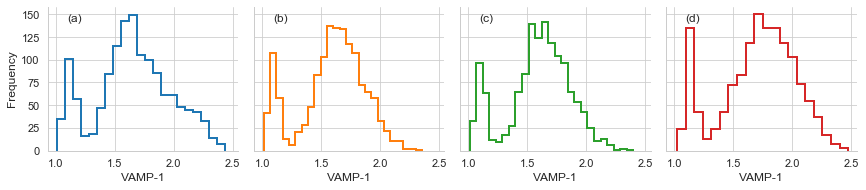

In [109]:
with sns.plotting_context('paper', font_scale=1.25):
    # Select sample
    sns.set_style('whitegrid')
    g = sns.FacetGrid(data=df, col='method', hue='method')
    g.map(sns.distplot, 'mean_test_score', hist=True, norm_hist=False, 
          hist_kws={'histtype': 'step', 'linewidth': 2, 'alpha': 1}, 
          kde=False)
    g.set(xlabel='VAMP-1')
    g.axes[0][0].set_ylabel('Frequency')
    # use this for presentation
#     g.set_titles('{col_name}') 
    g.set_titles('')
    for i, ax in enumerate(g.axes.flatten()):
        ax.annotate(s='({})'.format(list('abcdefg')[i]), xy=(0.1, 0.9), xycoords='axes fraction')
    plt.savefig('figures/score_method_distribution.png', bbox_inches='tight')


# Figure: ranked scores

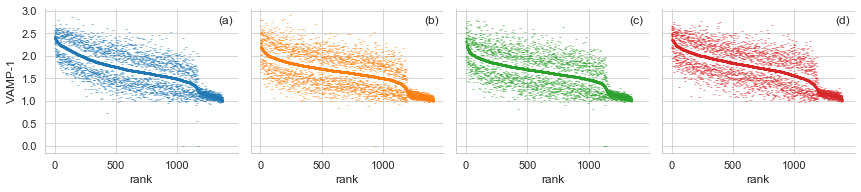

In [122]:

sample = df.copy()
sample.loc[:, 'rank'] = sample.groupby(['method'])['mean_test_score'].rank(ascending=False)


with sns.plotting_context('paper', font_scale=1.25):

    g = sns.FacetGrid(sample, col='method', hue='method')
    g.map(plt.scatter, 'rank', 'mean_test_score',  linewidth=0., marker='o', s=5)
    g.map(plt.scatter, 'rank', 'min_test_score', marker='_', s=2, lw=1, alpha=0.5)
    g.map(plt.scatter, 'rank', 'max_test_score', marker='_', s=2 , lw=1, alpha=0.5)
    g.set_titles('')
#     g.set(xlim=(0,10))
    g.axes[0][0].set_ylabel('VAMP-1')
    for i, ax in enumerate(g.axes.flatten()):
#         ax.invert_xaxis()
        ax.annotate(s='({})'.format(list('abcdefg')[i]), xy=(0.9, 0.9), xycoords='axes fraction')
    plt.savefig('figures/score_method_ranked.png')
#     g.set(ylim=(1.8,2.5))